In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnchoredText
import scipy.optimize
import pandas as pd
from IPython.display import clear_output
from time import sleep



# Exercise 7: Wolff Algorithm
This time, instead of a Metropolis ALgorithm with local spin flips, the WOlff Algorithm was implemented.
in this algorithm, a random spin of the system is chosen as a cluster center.Its nearest neighbours are added to the cluster if they share the spin of the center cluster with a probability 
$$P_{add} = 1- exp(-2 \beta J)$$ 

Then the whole cluster is flipped with probability 1. In my implementation, I flipp each cluster as it joins to prevent the algorithm to revisit neighbours  that have already joined the cluster. Neighbours that have not joined the cluster can still be revisited for a join attempt through other neighbours though.

Below is a little animation of the simulation at low temperatures.


In [2]:
#read in the data from csv file
data = []
with open('exercise7_sim_animation.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('int')
        data.append(np.reshape(array,(50,50)))


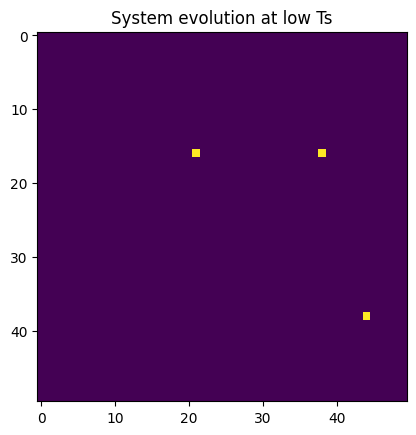

In [3]:

for i in range(40):
    plt.title("System evolution at low Ts")
    plt.imshow(data[i])
    plt.show()

    sleep(0.001)
    clear_output(wait=True)

## Cluster Size Statistics

The Probability to add a neighbour to the cluster, $P_{add}$ depends on the temperature through $\beta = \frac{1}{k_b T}$ . At very high temperatures beta becomes very small and thus $P_{add} \approx 0$, so it can be expected to find ecffectively moslty single spin flips and small clusters. For low temperatures, or large $\beta$, $P_{add} \approx 1$, so clusters can become so large that the whole system is joined. This can actually be seen in the above simulation, with the whole system flipping together.

This is further investigated below. The Ising model was simulated with the Wolff Algorithm at 3 different Temperatures:
$$T_l = 0.5 T_c, T_c= , T_h = 2 T_c$$
The cluster sizes during the Simulation were recorded and are plotted in Histogramms below


In [4]:
#read in the data from csv file
data = []
with open('exercise7_other.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    #next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('float')
        data.append(array)
Tc=2/np.log(1+np.sqrt(2))
Temperatures=[0.5*Tc, Tc,Tc*2]
print(Temperatures)
clustersizes=data[:3]
Magnetisations_Wolff= data[4:15:2]
clustersizes_corr=data[3:15:2]
Magnetisations_Metropolis= data[15:]
print(data[5])
print(len(Magnetisations_Metropolis))

[1.134592657106511, 2.269185314213022, 4.538370628426044]
[1.000e+00 1.000e+00 1.000e+00 ... 2.759e+03 1.000e+00 2.938e+03]
6


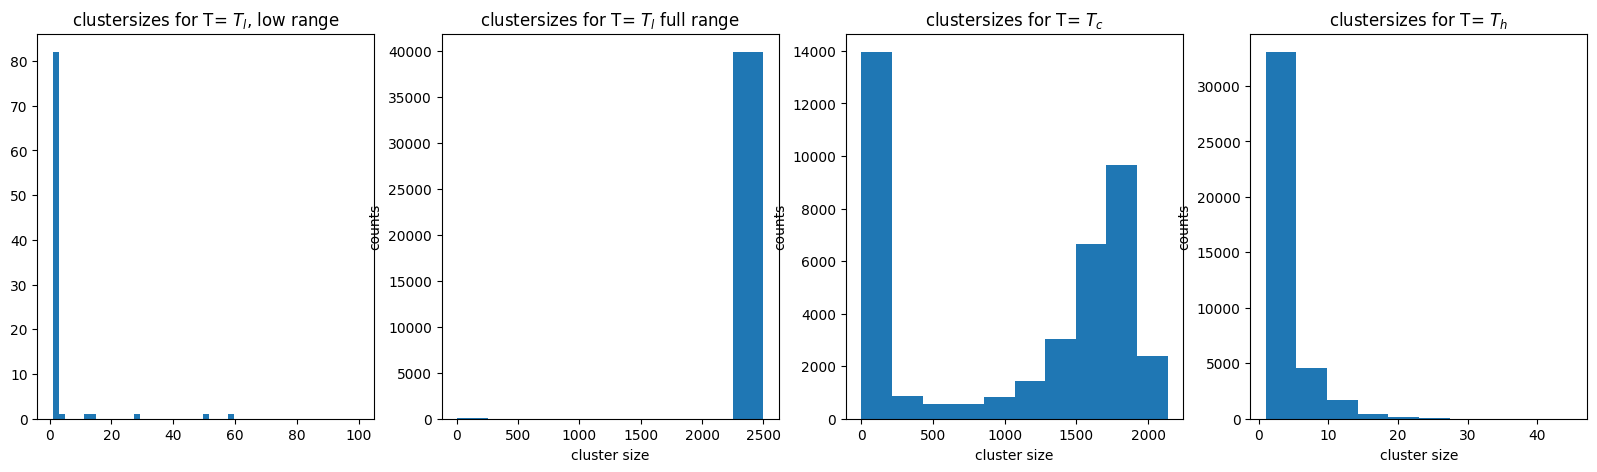

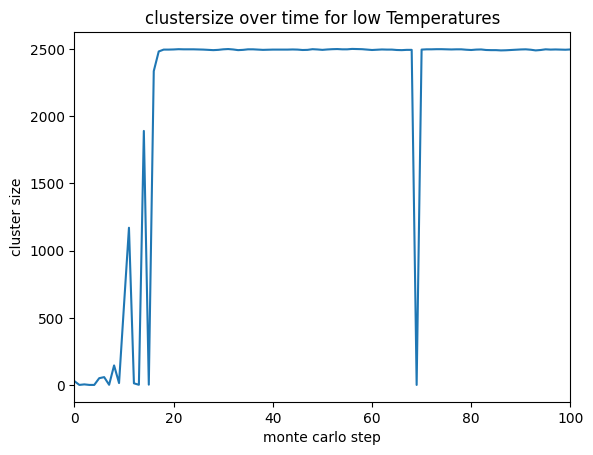

In [8]:
fig, axs= plt.subplots(1,4, figsize=(20,5))
titles=["clustersizes for T= $T_l$, low range","clustersizes for T= $T_l$ full range","clustersizes for T= $T_c$","clustersizes for T= $T_h$"]
axs[0].set_title(titles[0])
axs[0].hist(clustersizes[0],bins= np.linspace(1,100))
for i in range(1,4):
    axs[i].set_title(titles[i])
    axs[i].set_ylabel("counts")
    axs[i].set_xlabel("cluster size")
    axs[i].hist(clustersizes[i-1])
fig,ax = plt.subplots()  
ax.set_title("clustersize over time for low Temperatures") 
ax.set_xlim(0,100)
ax.set_xlabel("monte carlo step")
ax.set_ylabel("cluster size")
ax.plot(clustersizes[0])
plt.show()

One can clearly see the expected behaviour. At low temperatures, almost all clusters involve the whole system. By looking at the lower plot, it becomes quite clear that the few single spin flips and small clsuters seem to appear in the beginning of the simualtion. Close to the critical temperature a big range of cluster sizes appears, and at high temperatures, single spin flips and very small clusters dominate.


## Correlation time
For a range of system sizes, the Ising model was simulated with the Wolff Algorithm and the previously implemented local move Metropolis Algorithm. Then the correlation time of the Magnetisation was investigated for different system sizes close to the critical temperature. 

exponents z for L dependency of correlation time: Metropolis z_m = 2.33  +- 0.67; Wolff z_w = -0.19 +- 0.14


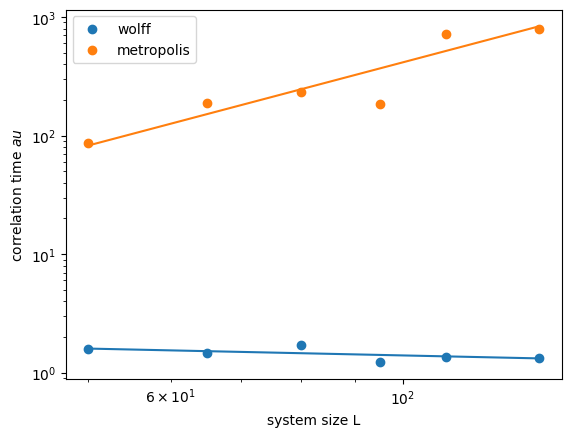

In [9]:
Ls=np.array([50,65,80,95,110,135])

def exp(x,tau,a):
    return a*np.exp(-x/tau)
def powerlaw(x,a,b):
    return(b*x**a)

def calc_autocorrellation(array, lag_max, t_eq):
    array=array[t_eq::]
    array_centered= array-np.average(array)
    N_samples= len(array)
    autocov = np.empty(lag_max)
    lagtimes=np.arange(0,lag_max)
    for j in range(lag_max):
        autocov[j] = np.dot(array_centered[:N_samples - j],array_centered[j:])
    autocov /= (N_samples-lagtimes)
    return autocov

lagmax=100
lagtimes=np.arange(0,lagmax)
k=0
auto_times_wolff=[]
auto_times_metropolis=[]

for i,L in enumerate(Ls):
    autocorr1= calc_autocorrellation(np.abs(Magnetisations_Wolff[i]),lagmax, t_eq=3000)
    popt1,pcov1=scipy.optimize.curve_fit(exp,lagtimes,autocorr1)
    
    auto_times_wolff.append(popt1[0])

    autocorr2=calc_autocorrellation(Magnetisations_Metropolis[i],lagmax, t_eq=3000)
    popt2,pcov2=scipy.optimize.curve_fit(exp,lagtimes,autocorr2)
    auto_times_metropolis.append(popt2[0])
auto_times_metropolis=np.array(auto_times_metropolis)
auto_times_wolff= np.array(auto_times_wolff)*np.mean(clustersizes_corr,axis=1)/np.array(Ls)**2
popt_m,pcov_m= scipy.optimize.curve_fit(powerlaw,Ls,auto_times_metropolis)
popt_w,pcov_w= scipy.optimize.curve_fit(powerlaw,Ls,auto_times_wolff)
print("exponents z for L dependency of correlation time: Metropolis z_m = %.2f  +- %.2f; Wolff z_w = %.2f +- %.2f"%(popt_m[0] , np.sqrt(pcov_m[0][0]),popt_w[0],np.sqrt(pcov_w[0][0])))
plt.xscale("log")
plt.yscale("log")

plt.xlabel("system size L")
plt.ylabel("correlation time $\tau$")
plt.scatter(Ls,auto_times_wolff,label="wolff")


plt.plot(Ls,powerlaw(Ls,*popt_w))
plt.plot(Ls,powerlaw(Ls,*popt_m))
plt.scatter(Ls,auto_times_metropolis,label="metropolis")
plt.legend()
plt.show()



One can clearly see that for the Wolff-Algorithm, the correlation time is at least two orders of magnitude lower than for the metropolis algorithm with local moves from a power law fit , we get an exponent that matches the theoretical value of $z_w \approx 0$.25$ very well. The correlation times also grow very uniformly with system size, with very small variance around the trend. The correlation times of the Metropolis algorithm with local moves are a lot more scattered and there is no clear power law visible in its relation to system size, although a simple linear fit results in an exponent of $z_M \approx 0.87$ The theoretical value in the script was around $z_{theo} = 2$, but because the error of the parameter fit is so large, it is still within a $1-\sigma$ interval of this theoretical value.
This really shows the strength of the Wolff-Algorithm; having a consistent behaviour for larger system sizes, that in  general has much lower correlation times, and avoids the critical slowing down seen in the previously discussed local Metropolis Algorithm,  makes for much more efficient and more nicely behaved simulations.

## Multiple Markov Chains

To decorrelate the trajectories, one can also simualte multiple Markov chains at different Temperatures, and allow swaps between different Temperatures according to a Metropolis rule that depends on their energy and temperaature difference:

$$ P_{swap} = $$
This only works if there is enough over lap in the energy distribution of the neighboring chains.




In [7]:
data = []
with open('exercise7_multipleMC.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('float')
        data.append(array)
print(np.shape(data))
print(data[2])
print(data[6])
print(data[2])

(18, 10)
[-1.6  -2.   -2.32 -2.4  -2.16 -2.24 -2.4  -2.4  -2.16 -2.32]
[-1.36 -1.84 -1.2  -1.12 -1.68 -1.2  -1.36 -0.96 -1.04 -0.56]
[-1.6  -2.   -2.32 -2.4  -2.16 -2.24 -2.4  -2.4  -2.16 -2.32]
